In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# Prepare the dataset

In [2]:
# Hyperparameters
batch_size = 128
latent_dim = 20  # Size of the latent space
epochs = 10      # Number of training epochs
learning_rate = 1e-3

# Transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:11<00:00, 885kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 92.8kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:02<00:00, 617kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.28MB/s]


# Defining the model

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # Flatten input
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Training the model

In [6]:
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}: Average loss: {train_loss / len(train_loader.dataset):.4f}')


Epoch 1: Average loss: 166.2617
Epoch 2: Average loss: 122.1283
Epoch 3: Average loss: 114.9614
Epoch 4: Average loss: 111.8887
Epoch 5: Average loss: 110.2067
Epoch 6: Average loss: 108.9584
Epoch 7: Average loss: 108.0503
Epoch 8: Average loss: 107.3877
Epoch 9: Average loss: 106.8521
Epoch 10: Average loss: 106.4080


# Reconstruction

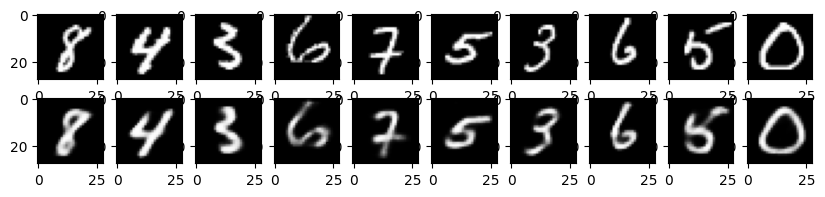

In [18]:
model.eval()
with torch.no_grad():
    # Take a test image
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, _, _ = model(data)
    
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[1, i].imshow(recon[i].cpu().squeeze().reshape(28, 28), cmap='gray')
    plt.show()


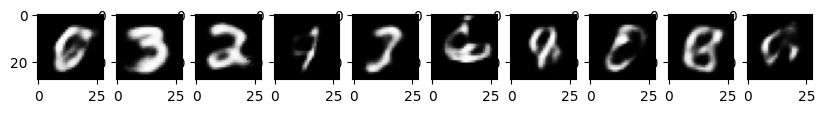

In [8]:
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)  # Sample from standard normal
    samples = model.decode(z).cpu()
    
    # Plot generated images
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for i in range(10):
        axes[i].imshow(samples[i].squeeze().reshape(28, 28), cmap='gray')
    plt.show()


In [13]:
def sample_specific_digit(model, test_loader, target_digit, num_samples=10, noise_level=0.5):
    model.eval()
    with torch.no_grad():
        # Find an example of the target digit
        for data, labels in test_loader:
            idx = (labels == target_digit).nonzero(as_tuple=True)[0]
            if len(idx) > 0:
                example = data[idx[0]].to(device)  # Take the first matching example
                break
        else:
            raise ValueError(f"No examples of digit {target_digit} found in test set.")
        
        # Encode to get mu and logvar
        mu, logvar = model.encode(example.view(-1, 784))
        std = torch.exp(0.5 * logvar)
        
        # Sample variations around mu
        samples = []
        for _ in range(num_samples):
            eps = torch.randn_like(std) * noise_level  # Adjust noise_level for more/less variation
            z = mu + eps * std
            recon = model.decode(z).cpu().squeeze().reshape(28, 28)
            samples.append(recon)
    
    return samples


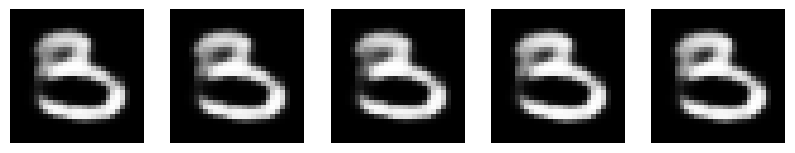

In [20]:
generated_2s = sample_specific_digit(model, test_loader, target_digit=3, num_samples=5, noise_level=0.3)

# Plot the generated samples (using matplotlib)
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, img in enumerate(generated_2s):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.show()
